In [1]:
from DLtools.Data import instant_data,intersection,del_less_col,station_sel,check_specific_col
from DLtools.feature_sel import call_mar
from DLtools.MachineLearning import test_stationarity,tsplot

import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(42)

# Load data

In [2]:
###### SETTING AREA ################
loading = instant_data()
df,mode,n_past,n_future = loading.hourly_instant(),'hour',24*7,72
# df,mode,n_past,n_future = loading.daily_instant(),'day',60,30

st = 'CPY012'
target,start_p,stop_p,host_path=station_sel(st,mode)
split_date = '2016-11-01'
save_path = host_path
#######################################################
def scope_data(data):
    global start_p,stop_p
    # return del_less_col(data[start_p:stop_p],0.8)
    return data[start_p:stop_p]
#######################################################
df_r = scope_data(loading.df_r)
df_w = scope_data(loading.df_w)
df_wet = scope_data(loading.df_wet)
df_dam = scope_data(loading.df_d)

df_solar = df_wet[check_specific_col(df_wet,'solar')]
df_rain1h = df_wet[check_specific_col(df_wet,'rain1h')]
df_temp = df_wet[check_specific_col(df_wet,'temp')]
df_press = df_wet[check_specific_col(df_wet,'press')]
df_humid = df_wet[check_specific_col(df_wet,'humid')]
#######################################################
# df_r = scope_data(loading.df_r)

* Filter ratio 80%, interpolation NaN

In [3]:
def move_column_inplace(df, col, pos):
    col = df.pop(col)
    df.insert(pos, col.name, col)
    return df

data = df[start_p:stop_p]
data = data.interpolate(limit=300000000,limit_direction='both').astype('float32')
data  = call_mar(data,target,mode,cutoff=0.3)
data = move_column_inplace(data,target,0)
print(len(data.columns))
data.columns

10


Index(['CPY012_wl', 'WAN005_wl', 'BKK021_wl', 'YOM012_wl', 'DNP028_press',
       'PIN004_wl', 'WAN003_wl', 'BKK013_wl', 'CPY006_wl', 'NAN009_wl'],
      dtype='object')

In [38]:
MARfile='./MAR_4(fulldate)/[CPY012]featurelist_MAR_hourly_Fullreport.csv'
mar = pd.read_csv(MARfile)

cutoff =0.3
cutoff_mar = mar.loc[(mar['rss']>cutoff)|(mar['gcv']>cutoff)]#|(mar['nb_subset']>cutoff)]

In [39]:
cutoff_mar.drop_duplicates('feature')

,feature,rss,gcv,nb_subset,timestep
0,CPY006_wl,0.75,0.75,0.07,1
20,BKK021_wl,0.36,0.36,0.15,16
21,WAN005_wl,0.35,0.35,0.06,16
60,WAN003_wl,0.48,0.48,0.13,34
65,YOM012_wl,0.46,0.46,0.44,36
68,DNP028_press,0.38,0.38,0.19,37
69,PIN004_wl,0.42,0.42,0.19,38
70,NAN009_wl,0.33,0.33,0.29,38
127,BKK013_wl,0.35,0.35,0.03,60


In [6]:
df_rainST = pd.read_csv(f'/home/song/Public/Song/Work/Thesis/data/hii-telemetering-batch-data-master/station_metadata-rain.csv')
df_waterST = pd.read_csv(f'/home/song/Public/Song/Work/Thesis/data/hii-telemetering-batch-data-master/station_metadata-water-level.csv')
df_weatherST = pd.read_csv(f'/home/song/Public/Song/Work/Thesis/data/hii-telemetering-weather-data-master/station_metadata.csv')

* filter ST only avaliable 80% data

In [7]:
def clean_list(df_st,sel_word):
    global data
    data_col = list(data.columns)
    data_col = [i.split("_") for i in data_col]
    _col =list()
    if sel_word=='':
        for i in data_col:_col.append(i[0])
    else:
        for i in data_col:
            if i[1]==sel_word : _col.append(i[0])
    dis_loc = intersection(_col,list(df_st['code']))
    df_st = df_st.loc[df_st['code'].isin(dis_loc)]
    return df_st

In [57]:
_dfwaterST = df_waterST.set_index('code').drop(index='CPY012').reset_index()

In [60]:
df_rainST = clean_list(df_weatherST,'rain1h')
df_waterST = clean_list(_dfwaterST,'wl')
df_pressST = clean_list(df_weatherST,'press')
CPY = df_waterST.loc[df_waterST['code']=='CPY012']


# Map display

In [18]:
import geopandas as gpd
path_w = "/home/song/Public/Song/Work/Thesis/data/map/Streams/River (PGIS).shp"
path_t = '/home/song/Public/Song/Work/Thesis/data/map/Th_map/thailand.shp'
watermap = gpd.read_file(path_w)
thaimap = gpd.read_file(path_t)

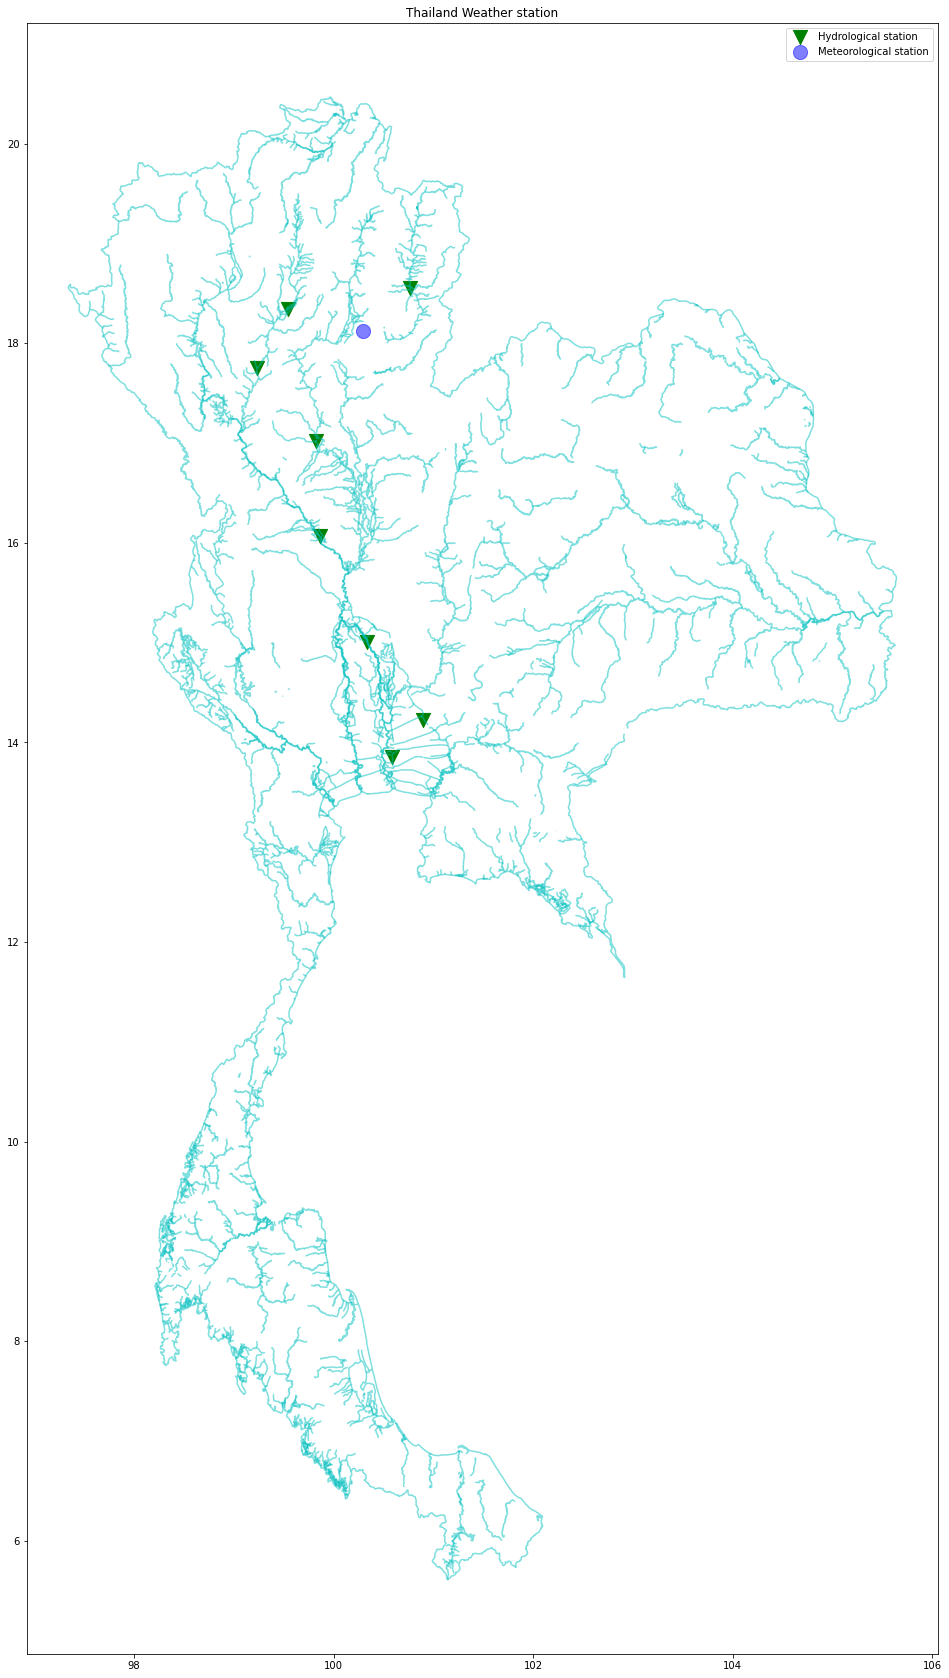

In [61]:
fig, ax = plt.subplots(1,figsize=(50,30))

# thai = thaimap.plot(axes=ax,color='white', edgecolor='lightgreen')
water = watermap.plot(ax=ax,color='c', edgecolor='dodgerblue',alpha=0.5)
# #station map
waterstation_map = gpd.GeoDataFrame(df_waterST, geometry=gpd.points_from_xy(df_waterST.long, df_waterST.lat))
CPY_station_map = gpd.GeoDataFrame(CPY, geometry=gpd.points_from_xy(CPY.long, CPY.lat))
rain_station_map = gpd.GeoDataFrame(df_rainST, geometry=gpd.points_from_xy(df_rainST.long, df_rainST.lat))
weather_station_map = gpd.GeoDataFrame(df_pressST, geometry=gpd.points_from_xy(df_pressST.long, df_pressST.lat))

ax.set_title('Thailand Weather station')
waterstation_map.plot(ax=ax, color='green',marker="v", markersize=200, legend=True, label= 'Hydrological station')
rain_station_map.plot(ax=ax, color='orange',marker="^",markersize=200, legend=True,label='Rain st')
weather_station_map.plot(ax=ax, color='blue',marker="o", markersize=200, legend=True,alpha=0.5, label= 'Meteorological station')
CPY_station_map.plot(ax=ax, color='red',marker="*",markersize=400, legend=True,alpha=0.8,label='Target station')
plt.legend(loc='upper right')
plt.savefig('watermap_hour_mar30.png')

In [12]:
# fig, ax = plt.subplots(1,figsize=(7,12))
# thai = thaimap.plot(axes=ax,color='white', edgecolor='lightgreen')
# water = watermap.plot(ax=ax,color='c', edgecolor='dodgerblue')
# # station
# rain_station_map = gpd.GeoDataFrame(df_rainST, geometry=gpd.points_from_xy(df_rainST.long, df_rainST.lat))

# ax.set_title('Thailand Rain station')
# rain_station_map.plot(ax=ax, color='orange',marker="x",markersize=5)
# CPY_station_map.plot(ax=ax, color='red',marker="o",markersize=25)
# plt.savefig('rainmap.png')

# Plot graph

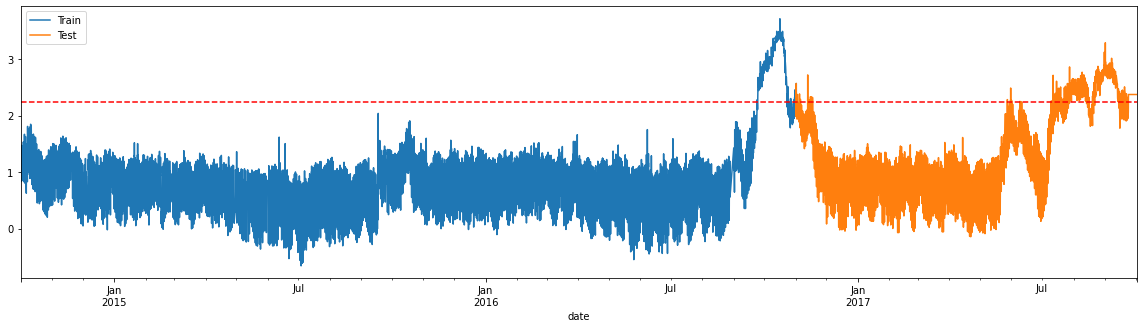

In [6]:
train, test = data[:split_date],data[split_date:]
train[target].plot(figsize=(20,5),label='Train')
test[target].plot(label='Test')
plt.axhline(2.24,color='r',ls='--')
plt.legend()
plt.savefig('cpy012.png')
#data[target].plot(figsize=(20,5))

In [10]:
test[target].to_csv('forARIMA_t.csv')

In [25]:
data

,CPY012_wl,BKK013_wl,PIN004_wl,WAN003_wl,BKK021_wl,NAN009_wl,WAN005_wl,CPY006_wl,YOM012_wl,DNP028_press
date,,,,,,,,,,
2014-10-01 00:00:00,1.473333,2.232000,41.020000,172.339996,1.854000,181.173340,231.861664,7.330000,47.641998,937.799988
2014-10-01 01:00:00,1.425000,2.230000,41.038666,172.345993,1.836667,181.145004,231.846664,7.330000,47.631668,937.799988
2014-10-01 02:00:00,1.360000,2.226667,41.057335,172.352005,1.816667,181.130005,231.839996,7.330000,47.619999,936.710022
2014-10-01 03:00:00,1.286667,2.230000,41.076000,172.358002,1.810000,181.113800,231.838806,7.330000,47.604801,936.710022
2014-10-01 04:00:00,1.215000,2.228333,41.094666,172.363998,1.794444,181.097595,231.837601,7.330000,47.589600,936.710022
...,...,...,...,...,...,...,...,...,...,...
2017-10-01 19:00:00,2.375000,2.811667,41.525002,173.363327,1.371667,180.880005,233.133331,11.150000,48.803333,932.369995
2017-10-01 20:00:00,2.375000,2.815000,41.518333,173.375000,1.361667,180.880005,233.143326,11.150000,48.808334,933.460022
2017-10-01 21:00:00,2.375000,2.811667,41.508335,173.391663,1.360000,180.880005,233.191666,11.145000,48.813332,934.539978


# Wavelet

In [26]:
import pywt

<AxesSubplot:xlabel='date'>

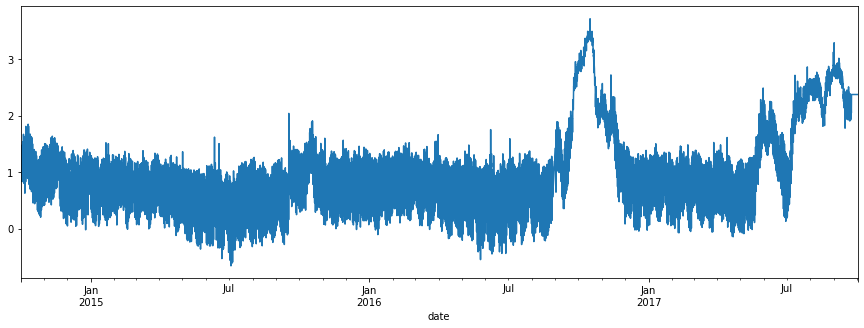

In [40]:
data[target].plot(figsize=(15,5))

In [48]:
signal=data[target]['2016':'2017-01-01']
coeff = pywt.swt(signal,'db4')
cA3,cD3,cD2,cD1 = coeff[0][0],coeff[0][1],coeff[1][1],coeff[2][1]

<AxesSubplot:xlabel='date'>

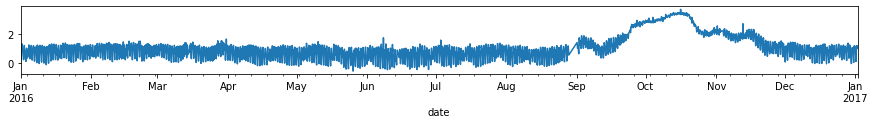

In [49]:
signal.plot(figsize=(15,5/4))

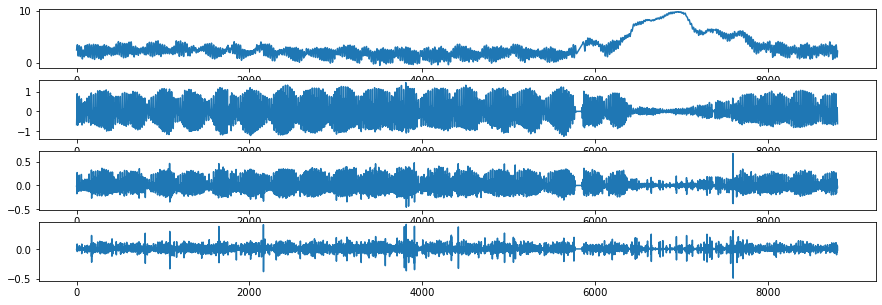

In [50]:
fig,ax = plt.subplots(4,1,figsize=(15,5))
ax[0].plot(cA3)
ax[1].plot(cD3)
ax[2].plot(cD2)
ax[3].plot(cD1)
fig.savefig('cpy012_wav.png')